In [1]:
from os import listdir, walk
from os.path import isfile, join
import numpy as np
from PIL import Image
import cv2
from IPython.display import display
import math, random
import time, datetime, sys, os, shutil
import operator

import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.layers import Input
from tensorflow.keras.utils import Sequence
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.callbacks import CSVLogger
from tensorflow.keras.optimizers import *

from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.model_selection import train_test_split
import pandas as pd

print(tf.config.experimental.list_physical_devices())

BATCH_SIZE = 32

%run ./variables.ipynb
%run ./utils.ipynb
%run ../utils/data_utils.ipynb

id_map = get_selected_taxons(SELECTED_TAXONS)
id_map_inv = get_selected_taxons(SELECTED_TAXONS, inv=True)
n_classes = len(list(id_map.keys()))
check_dirs(SAVED_MODELS_ROOT)

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:XLA_CPU:0', device_type='XLA_CPU'), PhysicalDevice(name='/physical_device:XLA_GPU:0', device_type='XLA_GPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


# Handle data

## Preparing panda arrays

In [2]:
X_train, y_train, _ = get_dataset(TRAIN_DATASET_PATH, ids=False)
X_test, y_test, _ = get_dataset(TEST_DATASET_PATH, ids=False)

print("Test length:", len(X_train), "- n classes:", len(np.unique(y_train)))
print("Test length:", len(X_test), "- n classes:", len(np.unique(y_test)))

# Balance dataset
train_dict = {}
for file, label in zip(X_train, y_train):
    train_dict.setdefault(label, []).append(file)
max_samples = np.max([len(train_dict[taxon_id]) for taxon_id in train_dict])
X_train = []
y_train = []
for taxon_id in train_dict:
    ratio = np.ceil(max_samples/len(train_dict[taxon_id]))
    tmp = np.repeat(train_dict[taxon_id], ratio)
    np.random.shuffle(tmp)
    train_dict[taxon_id] = tmp[0:max_samples]
    X_train.extend(tmp[0:max_samples])
    y_train.extend([taxon_id]*max_samples)
print("Balanced to", max_samples, "samples per class!")

'38/38'

'38/38'

Test length: 753 - n classes: 38
Test length: 84 - n classes: 38
Balanced to 26 samples per class!


In [3]:
data_train = {'png_path':  X_train, 'taxon_id': y_train}
data_test = {'png_path':  X_test, 'taxon_id': y_test}

df_train = pd.DataFrame(data_train, columns = ['png_path', 'taxon_id'])
df_test = pd.DataFrame(data_test, columns = ['png_path', 'taxon_id'])
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

# Prtining some infos
print(len(df_train), len(df_test))
df_train.head()
df_test.head()

988 84


,png_path,taxon_id
0,/mnt/nvme-storage/pfauregi/training/thumbails/...,Nitzschia_sinuata
1,/mnt/nvme-storage/pfauregi/training/thumbails/...,Navicula_radiosa
2,/mnt/nvme-storage/pfauregi/training/thumbails/...,Petroneis_humerosa
3,/mnt/nvme-storage/pfauregi/training/thumbails/...,Surirella_brebissonii
4,/mnt/nvme-storage/pfauregi/training/thumbails/...,Opephora_olsenii


## Setting up the flows

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255.,
                         rotation_range=180, 
                         brightness_range=[0.8,1.2], 
                         horizontal_flip=True, 
                         vertical_flip=True,
                         fill_mode='nearest',
                         width_shift_range=20,
                         height_shift_range=20,
                         zoom_range=0.2,
                         data_format="channels_last")

test_datagen = ImageDataGenerator(rescale=1./255.,
                         data_format="channels_last")

In [6]:
#classes_array = np.unique(y_train)
train_generator = train_datagen.flow_from_dataframe(
        dataframe=df_train,
        x_col='png_path',
        y_col='taxon_id',
        target_size=(256, 256),
        batch_size=32,
        #classes=classes_array,
        class_mode='categorical')
val_generator = test_datagen.flow_from_dataframe(
        dataframe=df_test,
        x_col='png_path',
        y_col='taxon_id',
        target_size=(256, 256),
        batch_size=32,
        classes=train_generator.class_indices,
        class_mode='categorical')

train_spe = train_generator.samples // BATCH_SIZE
val_spe = val_generator.samples // BATCH_SIZE

Found 988 validated image filenames belonging to 38 classes.
Found 84 validated image filenames belonging to 38 classes.


In [7]:
class_indices = train_generator.class_indices
f = open(os.path.join(SAVED_MODELS_ROOT, 'model_id_map.csv'), 'w')
with f:
    writer = csv.writer(f)
    writer.writerow(["taxon", "id"])
    for taxon in class_indices:
        writer.writerow([taxon, class_indices[taxon]])

## Testing

21


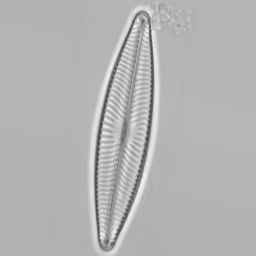

In [8]:
i = 0
stop = False
for batch in train_generator:
    images = batch[0]
    labels = batch[1]
    for i in range(images.shape[0]):
        print(np.argmax(labels[i]))
        image = (images[i,:,:,:]*255).astype('uint8')
        #print(image)
        display(Image.fromarray(image))
        i+=1
        if i>=1:
            stop = True
            break
    if stop: break;
    #display()

# Model desgin

In [9]:
# fetching base model
input_tensor = Input(shape=(256, 256, 3))
#base_model = InceptionV3(weights='imagenet', input_tensor=input_tensor, include_top=False)
base_model = Xception(include_top=False, weights='imagenet', input_tensor=input_tensor, pooling=None)

InternalError: CUDA runtime implicit initialization on GPU:0 failed. Status: out of memory

In [ ]:
# setting model for specifiv case
x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(1024, activation='relu')(x)
out = Dense(len(train_generator.class_indices.keys()), activation='softmax')(x)
model = Model(inputs=base_model.input, outputs=out)

# Training

## Setting callbacks

In [14]:
# Setting tensorboard
check_dirs(LOG_DIR)
delete_all_files_in_folder(LOG_DIR)
log_dir = LOG_DIR + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [15]:
log_file=os.path.join(SAVED_MODELS_ROOT, "model.log")
#os.remove(log_file)
csv_logger = CSVLogger(log_file, append=True)

## New layers only

In [16]:
n_epochs = 5
last_epoch = get_last_epoch(log_file)

print(n_epochs, "epochs composed of", train_spe, "batches (steps) of", BATCH_SIZE, "images.")

for layer in base_model.layers:
    layer.trainable = False
    
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(train_generator, 
          epochs=last_epoch+n_epochs, 
          steps_per_epoch=train_spe,
          use_multiprocessing=False, 
          validation_data=val_generator,
          validation_steps=val_spe,
          callbacks=[tensorboard_callback, csv_logger],
          initial_epoch=last_epoch)

5 epochs composed of 685 batches (steps) of 32 images.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 685 steps, validate for 27 steps
Epoch 1/5
685/685 [==============================] - 263s 384ms/step - loss: 1.5908 - accuracy: 0.5685 - val_loss: 5.8137 - val_accuracy: 0.1308
Epoch 2/5
685/685 [==============================] - 260s 380ms/step - loss: 0.9265 - accuracy: 0.7163 - val_loss: 6.3700 - val_accuracy: 0.1470
Epoch 3/5
685/685 [==============================] - 261s 380ms/step - loss: 0.8014 - accuracy: 0.7479 - val_loss: 7.0506 - val_accuracy: 0.1238
Epoch 4/5
685/685 [==============================] - 260s 380ms/step - loss: 0.7340 - accuracy: 0.7680 - val_loss: 7.0193 - val_accuracy: 0.1366
Epoch 5/5
685/685 [==============================] - 260s 380ms/step - loss: 0.6873 - accuracy: 0.7795 - val_loss: 7.8552 - val_accuracy: 0.1146


## Training full model

In [17]:
n_epochs = 30
last_epoch = get_last_epoch(log_file)

print(n_epochs, "epochs composed of", train_spe, "batches (steps) of", BATCH_SIZE, "images.")

# we chose to train the top 2 inception blocks, i.e. we will freeze
# the first 249 layers and unfreeze the rest:
for layer in model.layers:
    layer.trainable = True

# we need to recompile the model for these modifications to take effect
# we use SGD with a low learning rate
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# we train our model again (this time fine-tuning the top 2 inception blocks
# alongside the top Dense layers
model.fit(train_generator, 
          epochs=last_epoch+n_epochs, 
          steps_per_epoch=train_spe,
          use_multiprocessing=False, 
          validation_data=val_generator,
          validation_steps=val_spe,
          callbacks=[tensorboard_callback, csv_logger],
          initial_epoch=last_epoch)

30 epochs composed of 685 batches (steps) of 32 images.
  ...
    to  
  ['...']
  ...
    to  
  ['...']
Train for 685 steps, validate for 27 steps
Epoch 5/34
685/685 [==============================] - 268s 392ms/step - loss: 0.6547 - accuracy: 0.7913 - val_loss: 1.7800 - val_accuracy: 0.5845
Epoch 6/34
685/685 [==============================] - 265s 386ms/step - loss: 0.3228 - accuracy: 0.8911 - val_loss: 1.9044 - val_accuracy: 0.6053
Epoch 7/34
685/685 [==============================] - 265s 387ms/step - loss: 0.2472 - accuracy: 0.9188 - val_loss: 0.6302 - val_accuracy: 0.8206
Epoch 8/34
685/685 [==============================] - 265s 387ms/step - loss: 0.2130 - accuracy: 0.9293 - val_loss: 1.2585 - val_accuracy: 0.7130
Epoch 9/34
685/685 [==============================] - 265s 387ms/step - loss: 0.1830 - accuracy: 0.9391 - val_loss: 0.6367 - val_accuracy: 0.8299
Epoch 10/34
685/685 [==============================] - 265s 387ms/step - loss: 0.1671 - accuracy: 0.9460 - val_loss: 0.33

## Saving model

In [13]:
save_model(model, SAVED_MODELS_ROOT)

Saved model to /mnt/nvme-storage/pfauregi/training/thumbails/full/saved_models/model.json
Saved weights to /mnt/nvme-storage/pfauregi/training/thumbails/full/saved_models/model.h5


In [2]:
SAVED_MODELS_ROOT

'/mnt/nvme-storage/pfauregi/training/thumbails/aqualitas/saved_models/'